<a href="https://colab.research.google.com/github/sXeSociety/algorithms-massive-data-pagerank/blob/main/notebooks/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Algorithms for Massive Data – Project 3**
*Notebook 01 – Dataset Download, Setup & Initial Exploration*


In [1]:
%cd /content

# Import main libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from itertools import combinations
from pyspark.sql import SparkSession

repo_name = "algorithms-massive-data-pagerank"
repo_url = f"https://github.com/sXeSociety/{repo_name}.git"
repo_path = f"/content/{repo_name}"

# Check if repo already exists in /content. If it doesn't, clone the GitHub repo into /content
if not os.path.exists(repo_path):
    print(f"Repository not found in /content. Cloning {repo_name}...")
    !git clone $repo_url /content/{repo_name}
else:
    print(f"Repository already exists at {repo_path}. Skipping clone.")

# Change current working directory to the project root
%cd $repo_path

from src.utils_io import ensure_dirs
from src.load_data import download_dataset, load_ratings
from src.stats import describe_reviews
from src.preprocessing import build_core_dataset, build_core_subset
from src.mapping_ids import build_id_mappings
from src.graph_construction import build_book_cooccurrence_edges
from src.debug_utils import run_all_sanity_checks
from src.pagerank import pagerank_power_iteration

/content
Repository not found in /content. Cloning algorithms-massive-data-pagerank...
Cloning into '/content/algorithms-massive-data-pagerank'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 149 (delta 72), reused 124 (delta 61), pack-reused 0 (from 0)
Receiving objects: 100% (149/149), 364.44 KiB | 3.96 MiB/s, done.
Resolving deltas: 100% (72/72), done.
/content/algorithms-massive-data-pagerank


In [2]:
# Project root is now the current working directory
project_root = os.getcwd()
print("Project root:", project_root)

# Make sure we can import from the src package
if project_root not in sys.path:
    sys.path.append(project_root)

Project root: /content/algorithms-massive-data-pagerank


In [3]:
# Define data directories inside the project
data_dir = os.path.join(project_root, "data")
raw_dir = os.path.join(data_dir, "raw")
processed_dir = os.path.join(data_dir, "processed")

In [4]:
# Create data directories if they do not exist
ensure_dirs([data_dir, raw_dir, processed_dir])

Directory already exists: /content/algorithms-massive-data-pagerank/data
Directory already exists: /content/algorithms-massive-data-pagerank/data/raw
Directory already exists: /content/algorithms-massive-data-pagerank/data/processed


In [5]:
# Define some global variables
use_subsample = True
subsample_fraction = 0.05
seed = 42

In [6]:
# In the version saved on GitHub, keep "xxxxxx" for username and key.
# When running locally on Colab, replace "xxxxxx" with your actual credentials.
os.environ["KAGGLE_USERNAME"] = "andreacorradini"
os.environ["KAGGLE_KEY"] = "6ceb10d6edf30adf870d20004e90a5a5"

In [7]:
# Set the Kaggle dataset identifier
kaggle_dataset = "mohamedbakhet/amazon-books-reviews"

In [8]:
# Download the dataset from Kaggle only if it's not already present
download_dataset(raw_dir, kaggle_dataset)

# Load the ratings data, create a subsample and a cleaned version
df_ratings_clean = load_ratings(
    raw_dir=raw_dir,
    processed_dir=processed_dir,
    use_subsample=use_subsample,
    subsample_fraction=subsample_fraction,
    seed=seed,
)

Directory already exists: /content/algorithms-massive-data-pagerank/data/raw
Dataset not found in raw_dir, downloading from Kaggle.
Download extraction completed.
Files now in raw_dir:
 - Books_rating.csv
 - books_data.csv
 - .gitkeep
Directory already exists: /content/algorithms-massive-data-pagerank/data/processed
Using subsample mode.
Full dataset shape before subsample: (3000000, 10)
Subsampled dataset shape: (150000, 10)
Subsample saved to: /content/algorithms-massive-data-pagerank/data/processed/ratings_subsample.csv
Shape df_ratings_clean: (150000, 3)
                user_id     book_id  rating
2945667  A303XPDO694V6X  B0006CR6U4     4.0
2352586  A3780H4TM9RMB8  0897166159     2.0
1531260  A1AX6VPDQQZDPV  0736693408     5.0
941910   A35RQKCCCQ62O0  0395051029     4.0
2582125  A2IJQDE1I4SIJT  4770016050     5.0
Clean subsample saved in: /content/algorithms-massive-data-pagerank/data/processed/ratings_subsample_clean.csv


In [9]:
# Compute and print basic statistics on users, books and reviews
stats_dict = describe_reviews(df_ratings_clean)

Distinct users: 95746
Distinct books: 53940

Reviews per user:
min: 1
median: 1.0
mean: 1.28
max: 290

Reviews per book:
min: 1
median: 1.0
mean: 2.78
max: 339

Users with >= 2 reviews: 11647
Books with >= 2 reviews: 19848


In [10]:
# Build the core dataset to be used for the graph and PageRank
min_reviews = 2

df_core = build_core_dataset(
    df_ratings_clean=df_ratings_clean,
    processed_dir=processed_dir,
    min_reviews=min_reviews,
)

Shape df_core: (30736, 3)
Distinct users in core: 11104
Distinct books in core: 10592
                user_id     book_id  rating
941910   A35RQKCCCQ62O0  0395051029     4.0
2379833  A319KYEIAZ3SON  0670569798     5.0
2911594  A2X86K2EZCV0U1  B000GRDY1O     4.0
2682023  A1JLKPA3EPLFCP  0774032448     5.0
2306673  A1I2O9Y3X3HXLS  B000GRORC4     5.0
Core dataset saved in: /content/algorithms-massive-data-pagerank/data/processed/ratings_core_for_graph.csv


*Notebook 02 – Graph construction*


In [11]:
# Load df_core
df_core = pd.read_csv(os.path.join(processed_dir, "ratings_core_for_graph.csv"))

# Build the small dataset
df_core_small = build_core_subset(
    df_core=df_core,
    processed_dir=processed_dir,
    max_users=2000,
    save_name="ratings_core_small_for_graph.csv"
)


[build_core_subset] Limiting to first 2000 users.

[build_core_subset] Subset stats after filtering
Subset ratings: 5875
Subset distinct users: 2000
           user_id     book_id  rating
3   A1JLKPA3EPLFCP  0774032448     5.0
4   A1I2O9Y3X3HXLS  B000GRORC4     5.0
11  A11J17A2HNP5FQ  B0006EAC1C     4.0
12  A16R2I6AGL4NQW  1578210615     5.0
14  A1F8GH7CR68P59  B0007DWEOU     4.0
Core subset dataset saved in: /content/algorithms-massive-data-pagerank/data/processed/ratings_core_small_for_graph.csv


In [12]:
# Create integer index mappings for users and books
user_mapping, book_mapping, df_indexed = build_id_mappings(
    df_core_small=df_core_small,
    processed_dir=processed_dir,
    user_mapping_name="user_id_mapping_small.csv",
    book_mapping_name="book_id_mapping_small.csv",
    ratings_indexed_name="ratings_core_small_indexed.csv",
)

Directory already exists: /content/algorithms-massive-data-pagerank/data/processed

[build_id_mappings] Creating user/book integer index mappings...
[build_id_mappings] Saved user mapping:   /content/algorithms-massive-data-pagerank/data/processed/user_id_mapping_small.csv
[build_id_mappings] Saved book mapping:   /content/algorithms-massive-data-pagerank/data/processed/book_id_mapping_small.csv
[build_id_mappings] Saved indexed ratings: /content/algorithms-massive-data-pagerank/data/processed/ratings_core_small_indexed.csv


In [13]:
# Build the book co-occurrence edge list from the indexed small core dataset
edges_df = build_book_cooccurrence_edges(
    df_indexed=df_indexed,
    processed_dir=processed_dir,
    save_name="edges_books_core_small.csv",
    max_books_per_user=50,
    min_weight=1,
)

edges_df["weight"].describe()
edges_df["weight"].value_counts().head(10)

Directory already exists: /content/algorithms-massive-data-pagerank/data/processed

[build_book_cooccurrence_edges] Building book co-occurrence graph...
[build_book_cooccurrence_edges] Number of distinct edges: 13367

[build_book_cooccurrence_edges] Edge list (first rows):
   src_book_idx  dst_book_idx  weight
0          3338          3602       3
1          2599          3243       3
2          2605          3558       1
3          1378          3504       2
4          1798          3488       1
[build_book_cooccurrence_edges] Edge list saved in: /content/algorithms-massive-data-pagerank/data/processed/edges_books_core_small.csv


,count
weight,
1,13230
2,110
3,21
4,5
5,1


*Notebook 03 – PageRank Implementation*


In [14]:
# Define a small toy graph with 4 nodes.
# Edges: 0 -> 1, 1 -> 2, 3 -> 2, 2 -> 0
# Node 2 receives incoming links from 0, 1 and 3.
# Node 3 receives no incoming links.

num_nodes_toy = 4
# Source and destination node arrays
src_toy = np.array([0, 1, 3, 2], dtype=int)
dst_toy = np.array([1, 2, 2, 0], dtype=int)

# Run PageRank on the toy graph
ranks_toy = pagerank_power_iteration(
    num_nodes=num_nodes_toy,
    src_nodes=src_toy,
    dst_nodes=dst_toy,
    damping=0.85,
    tol=1e-8,
    max_iter=100,
    verbose=True
)

# Print results
print("\nToy graph PageRank:")
print("ranks:", ranks_toy)
print("sum:  ", ranks_toy.sum())
print("min:  ", ranks_toy.min())
print("max:  ", ranks_toy.max())

[pagerank] Starting power iteration...
[pagerank] num_nodes = 4
[pagerank] damping = 0.85
[pagerank] tol = 1e-08
[pagerank] max_iter = 100
[pagerank] teleport term = 0.037500000000000006
[pagerank] Iteration   1 - diff = 4.250000e-01
[pagerank] Iteration   2 - diff = 3.612500e-01
[pagerank] Iteration   3 - diff = 3.070625e-01
[pagerank] Iteration   4 - diff = 2.610031e-01
[pagerank] Iteration   5 - diff = 2.218527e-01
[pagerank] Iteration   6 - diff = 1.885748e-01
[pagerank] Iteration   7 - diff = 1.602885e-01
[pagerank] Iteration   8 - diff = 1.362453e-01
[pagerank] Iteration   9 - diff = 1.158085e-01
[pagerank] Iteration  10 - diff = 9.843720e-02
[pagerank] Iteration  11 - diff = 8.367162e-02
[pagerank] Iteration  12 - diff = 7.112088e-02
[pagerank] Iteration  13 - diff = 6.045275e-02
[pagerank] Iteration  14 - diff = 5.138483e-02
[pagerank] Iteration  15 - diff = 4.367711e-02
[pagerank] Iteration  16 - diff = 3.712554e-02
[pagerank] Iteration  17 - diff = 3.155671e-02
[pagerank] Ite

In [15]:
# Apply the same algorithm on edges_df
# Number of nodes = number of books
num_nodes = len(book_mapping)

# Build directed edges from the undirected co-occurrence graph
src_nodes = np.concatenate([
    edges_df["src_book_idx"].values,
    edges_df["dst_book_idx"].values,
])
dst_nodes = np.concatenate([
    edges_df["dst_book_idx"].values,
    edges_df["src_book_idx"].values,
])

ranks = pagerank_power_iteration(
    num_nodes=num_nodes,
    src_nodes=src_nodes,
    dst_nodes=dst_nodes,
    damping=0.85,
    tol=1e-6,
    max_iter=100,
    verbose=True,
)

[pagerank] Starting power iteration...
[pagerank] num_nodes = 3678
[pagerank] damping = 0.85
[pagerank] tol = 1e-06
[pagerank] max_iter = 100
[pagerank] teleport term = 4.0783034257748784e-05
[pagerank] Iteration   1 - diff = 3.739976e-01
[pagerank] Iteration   2 - diff = 1.247170e-01
[pagerank] Iteration   3 - diff = 5.032437e-02
[pagerank] Iteration   4 - diff = 3.006602e-02
[pagerank] Iteration   5 - diff = 1.971532e-02
[pagerank] Iteration   6 - diff = 1.357724e-02
[pagerank] Iteration   7 - diff = 9.861784e-03
[pagerank] Iteration   8 - diff = 7.276962e-03
[pagerank] Iteration   9 - diff = 5.517470e-03
[pagerank] Iteration  10 - diff = 4.225116e-03
[pagerank] Iteration  11 - diff = 3.288486e-03
[pagerank] Iteration  12 - diff = 2.577033e-03
[pagerank] Iteration  13 - diff = 2.040581e-03
[pagerank] Iteration  14 - diff = 1.625851e-03
[pagerank] Iteration  15 - diff = 1.305360e-03
[pagerank] Iteration  16 - diff = 1.053082e-03
[pagerank] Iteration  17 - diff = 8.548321e-04
[pagerank

In [16]:
# Attach PageRank scores to books
book_ranks = book_mapping.copy()
book_ranks["pagerank"] = ranks
print("Shape book_ranks:", book_ranks.shape)
print(book_ranks.head())

# Sort by PageRank and inspect top books
top_books = book_ranks.sort_values("pagerank", ascending=False).head(20)
print(top_books)

# Save
pagerank_path = os.path.join(processed_dir, "book_pagerank_small.csv")
book_ranks.to_csv(pagerank_path, index=False)
print(f"Saved PageRank scores to: {pagerank_path}")

Shape book_ranks: (3678, 3)
      book_id  book_idx  pagerank
0  0001050184         0  0.000332
1  0002155400         1  0.000408
2  0002222922         2  0.000473
3  0002243822         3  0.000299
4  0003300277         4  0.000503
         book_id  book_idx  pagerank
3250  B000NHNM3C      3250  0.002076
1190  1570020981      1190  0.001710
781   0786135034       781  0.001605
3338  B000NWQXBA      3338  0.001601
266   0393097730       266  0.001483
111   0192839020       111  0.001299
3573  B000PL29OO      3573  0.001279
1303  1591090245      1303  0.001254
2358  B000EANQJ8      2358  0.001116
1850  B0006E2W9M      1850  0.001108
377   0451518845       377  0.001091
3339  B000NWSQQ0      3339  0.001084
1171  1566190932      1171  0.001065
2126  B00085AKXO      2126  0.001024
500   0613674650       500  0.000997
1642  B0000YSH4W      1642  0.000992
2379  B000F6H01Q      2379  0.000972
1215  1578152445      1215  0.000966
2323  B000C1X8JC      2323  0.000960
3529  B000PCESRE      3529  

In [17]:
# Summary
print("PageRank sum:      ", ranks.sum())
print("PageRank min value:", ranks.min())
print("PageRank max value:", ranks.max())
print("Any NaN:", np.isnan(ranks).any())

PageRank sum:       1.0
PageRank min value: 4.4879946144064634e-05
PageRank max value: 0.0020762654237739663
Any NaN: False


*Notebook 04 – Build a big version of the core dataset and compute PageRank on it*


In [18]:
# We start again from df_core, which is the global core
# Step 1: build a bigger subset of the core dataset
max_users_big = 20000
df_core_big = build_core_subset(
    df_core=df_core,
    processed_dir=processed_dir,
    max_users=max_users_big,
    save_name="ratings_core_big_for_graph.csv",
)

print("\n[Big core] df_core_big shape:", df_core_big.shape)
print("[Big core] distinct users:", df_core_big["user_id"].nunique())
print("[Big core] distinct books:", df_core_big["book_id"].nunique())


[build_core_subset] Limiting to first 11104 users.

[build_core_subset] Subset stats after filtering
Subset ratings: 30736
Subset distinct users: 11104
          user_id     book_id  rating
0  A35RQKCCCQ62O0  0395051029     4.0
1  A319KYEIAZ3SON  0670569798     5.0
2  A2X86K2EZCV0U1  B000GRDY1O     4.0
3  A1JLKPA3EPLFCP  0774032448     5.0
4  A1I2O9Y3X3HXLS  B000GRORC4     5.0
Core subset dataset saved in: /content/algorithms-massive-data-pagerank/data/processed/ratings_core_big_for_graph.csv

[Big core] df_core_big shape: (30736, 3)
[Big core] distinct users: 11104
[Big core] distinct books: 10592


In [19]:
# Step 2: build integer index mappings for the big core
user_mapping_big, book_mapping_big, df_indexed_big = build_id_mappings(
    df_core_small=df_core_big,  # function only needs user_id and book_id
    processed_dir=processed_dir,
    user_mapping_name="user_id_mapping_big.csv",
    book_mapping_name="book_id_mapping_big.csv",
    ratings_indexed_name="ratings_core_big_indexed.csv",
)

print("\n[Big core] user_mapping_big shape:", user_mapping_big.shape)
print("[Big core] book_mapping_big shape:", book_mapping_big.shape)
print("[Big core] df_indexed_big shape:", df_indexed_big.shape)

Directory already exists: /content/algorithms-massive-data-pagerank/data/processed

[build_id_mappings] Creating user/book integer index mappings...
[build_id_mappings] Saved user mapping:   /content/algorithms-massive-data-pagerank/data/processed/user_id_mapping_big.csv
[build_id_mappings] Saved book mapping:   /content/algorithms-massive-data-pagerank/data/processed/book_id_mapping_big.csv
[build_id_mappings] Saved indexed ratings: /content/algorithms-massive-data-pagerank/data/processed/ratings_core_big_indexed.csv

[Big core] user_mapping_big shape: (11104, 2)
[Big core] book_mapping_big shape: (10592, 2)
[Big core] df_indexed_big shape: (30736, 5)


In [20]:
# Step 3: build the book co-occurrence edge list for the big core
edges_df_big = build_book_cooccurrence_edges(
    df_indexed=df_indexed_big,
    processed_dir=processed_dir,
    save_name="edges_books_core_big.csv",
    max_books_per_user=50,
    min_weight=1,
)

print("\n[Big graph] edges_df_big shape:", edges_df_big.shape)

Directory already exists: /content/algorithms-massive-data-pagerank/data/processed

[build_book_cooccurrence_edges] Building book co-occurrence graph...
[build_book_cooccurrence_edges] Number of distinct edges: 59205

[build_book_cooccurrence_edges] Edge list (first rows):
   src_book_idx  dst_book_idx  weight
0          9694         10401      14
1          7762          9452      13
2          7773         10277       6
3          4465         10173       3
4          5543         10139       3
[build_book_cooccurrence_edges] Edge list saved in: /content/algorithms-massive-data-pagerank/data/processed/edges_books_core_big.csv

[Big graph] edges_df_big shape: (59205, 3)


In [21]:
# Quick comparison small vs big
print("\n[Comparison] Small vs Big graph:")
print("  small - books (nodes):", len(book_mapping))
print("  small - edges:        ", len(edges_df))
print("  big   - books (nodes):", len(book_mapping_big))
print("  big   - edges:        ", len(edges_df_big))


[Comparison] Small vs Big graph:
  small - books (nodes): 3678
  small - edges:         13367
  big   - books (nodes): 10592
  big   - edges:         59205


In [22]:
# Step 4: run sanity checks on the big graph as well
run_all_sanity_checks(
    df_core_small=df_core_big,
    df_indexed=df_indexed_big,
    user_mapping=user_mapping_big,
    book_mapping=book_mapping_big,
    edges_df=edges_df_big,
)


[Sanity 1] Unique counts in df_core_small:
Users in df_core_small: 11104
Books in df_core_small: 10592

[Sanity 1] Mapping sizes:
Rows in user_mapping: 11104
Rows in book_mapping: 10592
[Sanity 1] OK: mapping cardinalities match the small core dataset.

[Sanity 2] Graph size:
Number of nodes (books): 10592
Number of edges:         59205

[Sanity 3] Edge list head:
   src_book_idx  dst_book_idx  weight
0          9694         10401      14
1          7762          9452      13
2          7773         10277       6
3          4465         10173       3
4          5543         10139       3

[Sanity 3] Edge list dtypes:
src_book_idx    int64
dst_book_idx    int64
weight          int64
dtype: object

[Sanity 3] Edge weight range:
min weight: 1
max weight: 14
[Sanity 3] OK: weights look consistent (>= 1).

[Sanity 4] Example user_idx selected: 5734
[Sanity 4] Books reviewed by this user: [np.int64(3032), np.int64(5995), np.int64(7264), np.int64(8099), np.int64(8619), np.int64(9362)]
[Sanit

In [23]:
# Step 5: PageRank on the big graph
# Number of nodes in the big graph = number of books in the big mapping
num_nodes_big = len(book_mapping_big)
print("\n[PageRank big] num_nodes_big:", num_nodes_big)

# Build directed edges from the undirected big co-occurrence graph
src_nodes_big = np.concatenate([
    edges_df_big["src_book_idx"].values,
    edges_df_big["dst_book_idx"].values,])
dst_nodes_big = np.concatenate([
    edges_df_big["dst_book_idx"].values,
    edges_df_big["src_book_idx"].values,])
print("[PageRank big] Number of directed edges:", len(src_nodes_big))

# Run PageRank on the big graph
ranks_big = pagerank_power_iteration(
    num_nodes=num_nodes_big,
    src_nodes=src_nodes_big,
    dst_nodes=dst_nodes_big,
    damping=0.85,
    tol=1e-6,
    max_iter=100,
    verbose=False,
)


[PageRank big] num_nodes_big: 10592
[PageRank big] Number of directed edges: 118410


In [24]:
# Attach PageRank scores to the big book mapping
book_ranks_big = book_mapping_big.copy()
book_ranks_big["pagerank"] = ranks_big
print("\n[PageRank big] book_ranks_big head:")
print(book_ranks_big.head())

# Inspect top books by PageRank in the big graph
top_books_big = book_ranks_big.sort_values("pagerank", ascending=False).head(20)
print("\n[PageRank big] Top 20 books by PageRank:")
print(top_books_big)

# Save the PageRank scores for the big graph
pagerank_big_path = os.path.join(processed_dir, "book_pagerank_big.csv")
book_ranks_big.to_csv(pagerank_big_path, index=False)
print(f"\n[PageRank big] Saved PageRank scores to: {pagerank_big_path}")


[PageRank big] book_ranks_big head:
      book_id  book_idx  pagerank
0  0001047655         0  0.000015
1  0001047825         1  0.000192
2  0001050184         2  0.000124
3  0001055003         3  0.000041
4  0002155400         4  0.000375

[PageRank big] Top 20 books by PageRank:
          book_id  book_idx  pagerank
7522   B000GROP62      7522  0.000970
2548   0786135034      2548  0.000896
10200  B000PC54NG     10200  0.000848
7384   B000GL8UMI      7384  0.000840
9694   B000NWQXBA      9694  0.000828
2889   0808510258      2889  0.000827
9464   B000NHNM3C      9464  0.000802
4710   8188280046      4710  0.000800
9534   B000NPEWHE      9534  0.000785
5697   B0006E2W9M      5697  0.000776
5993   B0007C10MS      5993  0.000772
10557  B000TZ19TC     10557  0.000768
1058   0435126075      1058  0.000766
5132   B0000YSH4W      5132  0.000746
7523   B000GROPF8      7523  0.000740
6894   B00097DWY0      6894  0.000728
4276   1593351348      4276  0.000716
1262   0451521196      1262  0.00

In [25]:
# Quick sanity check on the PageRank vector
print("\n[PageRank big] Summary stats")
print("  sum:     ", ranks_big.sum())
print("  min:     ", ranks_big.min())
print("  max:     ", ranks_big.max())
print("  any NaN: ", np.isnan(ranks_big).any())


[PageRank big] Summary stats
  sum:      1.0
  min:      1.5215373613499082e-05
  max:      0.0009702335208242775
  any NaN:  False


*Notebook 05 – Degree Distribution*


In [26]:
# Degree distribution: small vs big graph
# Create a directory for figures
figs_dir = os.path.join(processed_dir, "figs")
ensure_dirs([figs_dir])

# Degree = number of incident edges
# Each occurrence in src or dst contributes 1 to the degree
degree_small = pd.concat(
    [edges_df["src_book_idx"], edges_df["dst_book_idx"]]).value_counts()
degree_big = pd.concat(
    [edges_df_big["src_book_idx"], edges_df_big["dst_book_idx"]]).value_counts()

print("\n[Degree] Small graph degree stats:")
print(degree_small.describe())
print("\n[Degree] Big graph degree stats:")
print(degree_big.describe())

Created directory: /content/algorithms-massive-data-pagerank/data/processed/figs

[Degree] Small graph degree stats:
count    3283.000000
mean        8.143162
std        10.831330
min         1.000000
25%         1.000000
50%         4.000000
75%        10.000000
max       105.000000
Name: count, dtype: float64

[Degree] Big graph degree stats:
count    9729.000000
mean       12.170829
std        17.693166
min         1.000000
25%         2.000000
50%         5.000000
75%        15.000000
max       182.000000
Name: count, dtype: float64


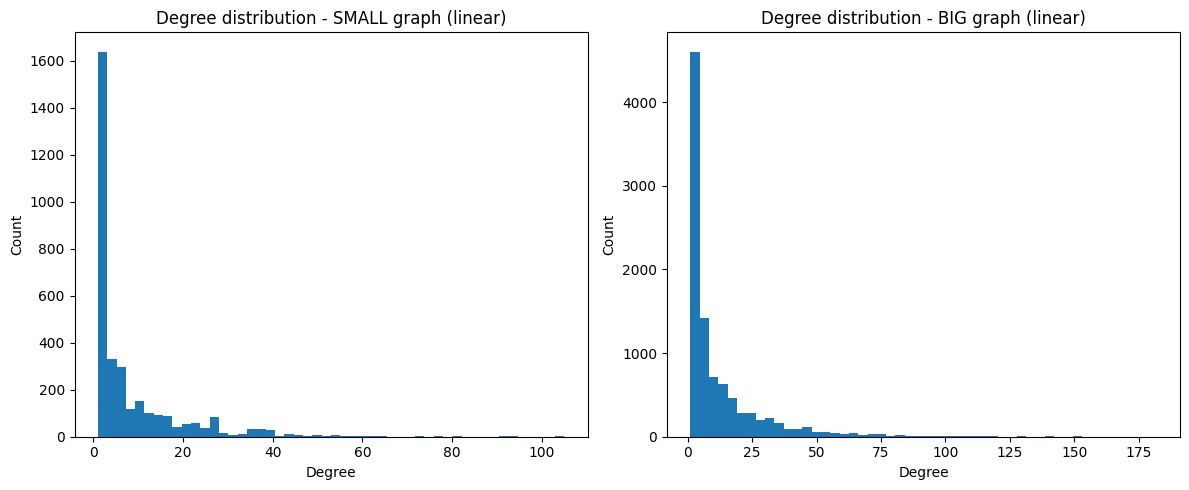

In [27]:
# Histogram of degree - Small vs. Big
plt.figure(figsize=(12, 5))
# Small
plt.subplot(1, 2, 1)
plt.hist(degree_small.values, bins=50)
plt.title("Degree distribution - SMALL graph (linear)")
plt.xlabel("Degree")
plt.ylabel("Count")
# Big
plt.subplot(1, 2, 2)
plt.hist(degree_big.values, bins=50)
plt.title("Degree distribution - BIG graph (linear)")
plt.xlabel("Degree")
plt.ylabel("Count")

plt.tight_layout()
degree_fig_linear_path = os.path.join(figs_dir, "degree_distribution_small_vs_big_linear.png")
plt.savefig(degree_fig_linear_path, dpi=150)
plt.show()
plt.close()

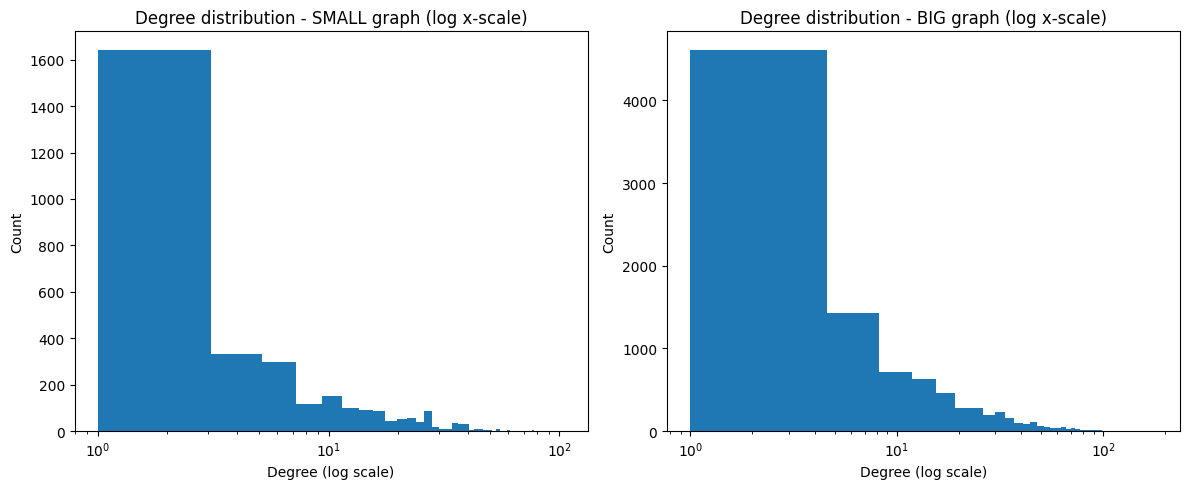

In [28]:
# Histogram of degree (log x-scale) - Small vs. Big
# To avoid issues with log(0), we keep only nodes with degree >= 1
degree_small_pos = degree_small[degree_small >= 1]
degree_big_pos = degree_big[degree_big >= 1]

plt.figure(figsize=(12, 5))
# Small
plt.subplot(1, 2, 1)
plt.hist(degree_small_pos.values, bins=50)
plt.xscale("log")
plt.title("Degree distribution - SMALL graph (log x-scale)")
plt.xlabel("Degree (log scale)")
plt.ylabel("Count")
# Big
plt.subplot(1, 2, 2)
plt.hist(degree_big_pos.values, bins=50)
plt.xscale("log")
plt.title("Degree distribution - BIG graph (log x-scale)")
plt.xlabel("Degree (log scale)")
plt.ylabel("Count")

plt.tight_layout()
degree_fig_logx_path = os.path.join(figs_dir, "degree_distribution_small_vs_big_logx.png")
plt.savefig(degree_fig_logx_path, dpi=150)
plt.show()
plt.close()

*Notebook 06 – Edge Weight Distribution*


In [29]:
# Extract edge weights
weights_small = edges_df["weight"].values
weights_big = edges_df_big["weight"].values
print("\n[Edge Weights] Small graph weight stats:")
print(pd.Series(weights_small).describe())
print("\n[Edge Weights] Big graph weight stats:")
print(pd.Series(weights_big).describe())


[Edge Weights] Small graph weight stats:
count    13367.000000
mean         1.012793
std          0.137530
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
dtype: float64

[Edge Weights] Big graph weight stats:
count    59205.000000
mean         1.052090
std          0.414123
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         14.000000
dtype: float64


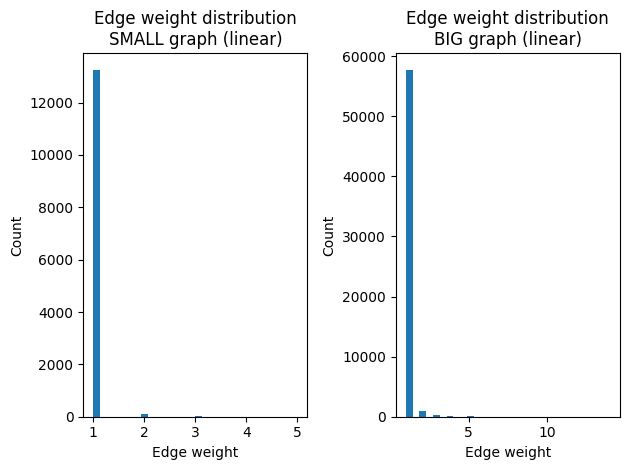

In [30]:
# Histogram of edge weights - Small vs. Big
# Small
plt.subplot(1, 2, 1)
plt.hist(weights_small, bins=30)
plt.title("Edge weight distribution\nSMALL graph (linear)")
plt.xlabel("Edge weight")
plt.ylabel("Count")
# Big
plt.subplot(1, 2, 2)
plt.hist(weights_big, bins=30)
plt.title("Edge weight distribution\nBIG graph (linear)")
plt.xlabel("Edge weight")
plt.ylabel("Count")

plt.tight_layout()
weights_fig_linear_path = os.path.join(figs_dir, "edge_weights_small_vs_big_linear.png")
plt.savefig(weights_fig_linear_path, dpi=150)
plt.show()
plt.close()

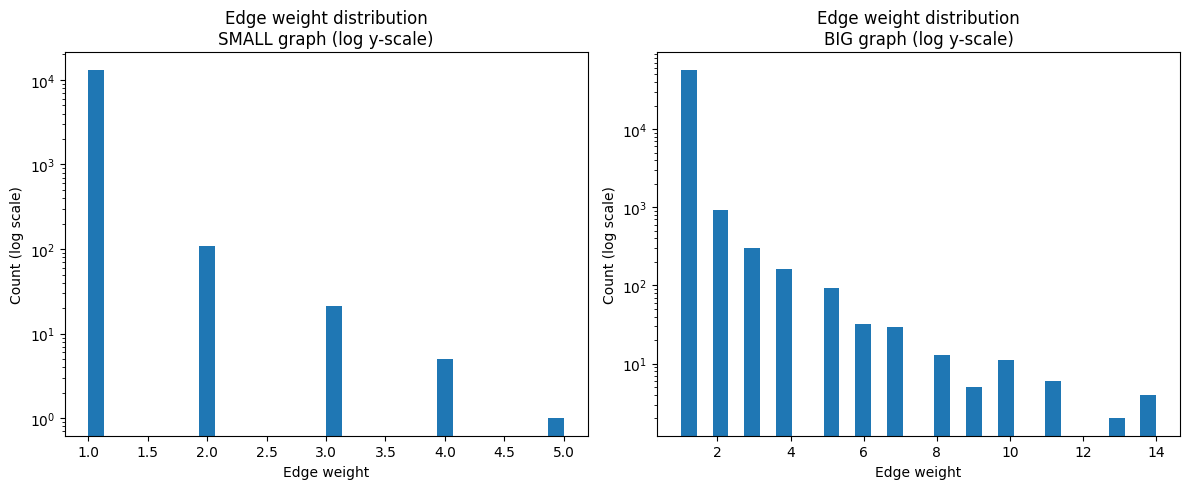

In [31]:
# Histogram of edge weights (log y-scale) - Small vs. Big
# Small
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(weights_small, bins=30)
plt.yscale("log")
plt.title("Edge weight distribution\nSMALL graph (log y-scale)")
plt.xlabel("Edge weight")
plt.ylabel("Count (log scale)")
# Big
plt.subplot(1, 2, 2)
plt.hist(weights_big, bins=30)
plt.yscale("log")
plt.title("Edge weight distribution\nBIG graph (log y-scale)")
plt.xlabel("Edge weight")
plt.ylabel("Count (log scale)")

plt.tight_layout()
weights_fig_logy_path = os.path.join(figs_dir, "edge_weights_small_vs_big_logy.png")
plt.savefig(weights_fig_logy_path, dpi=150)
plt.show()
plt.close()

*Notebook 07 – PageRank Distribution*


In [32]:
# Extract PageRank values as numpy arrays
pagerank_small_path = os.path.join(processed_dir, "book_pagerank_small.csv")
pagerank_big_path = os.path.join(processed_dir, "book_pagerank_big.csv")
book_ranks_small = pd.read_csv(pagerank_small_path)
book_ranks_big = pd.read_csv(pagerank_big_path)
pr_small = book_ranks_small["pagerank"].values
pr_big = book_ranks_big["pagerank"].values

print("\n[PageRank dist] Small graph PageRank stats:")
print(pd.Series(pr_small).describe())
print("\n[PageRank dist] Big graph PageRank stats:")
print(pd.Series(pr_big).describe())


[PageRank dist] Small graph PageRank stats:
count    3678.000000
mean        0.000272
std         0.000169
min         0.000045
25%         0.000156
50%         0.000299
75%         0.000320
max         0.002076
dtype: float64

[PageRank dist] Big graph PageRank stats:
count    10592.000000
mean         0.000094
std          0.000088
min          0.000015
25%          0.000038
50%          0.000076
75%          0.000110
max          0.000970
dtype: float64


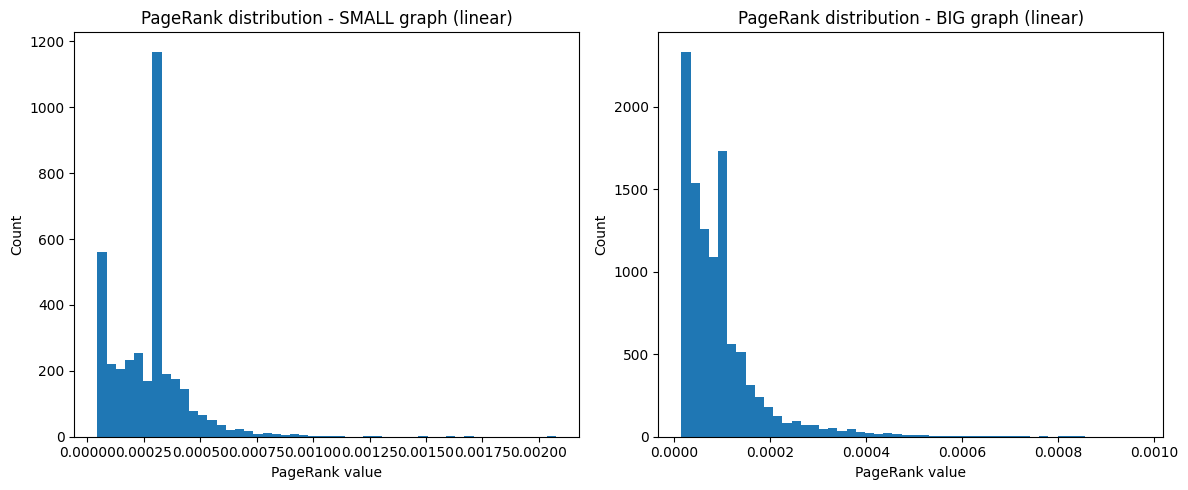

In [33]:
# Histogram of PageRank - Small vs. Big
plt.figure(figsize=(12, 5))
# Small
plt.subplot(1, 2, 1)
plt.hist(pr_small, bins=50)
plt.title("PageRank distribution - SMALL graph (linear)")
plt.xlabel("PageRank value")
plt.ylabel("Count")
# Big
plt.subplot(1, 2, 2)
plt.hist(pr_big, bins=50)
plt.title("PageRank distribution - BIG graph (linear)")
plt.xlabel("PageRank value")
plt.ylabel("Count")

plt.tight_layout()
pr_fig_linear_path = os.path.join(figs_dir, "pagerank_distribution_small_vs_big_linear.png")
plt.savefig(pr_fig_linear_path, dpi=150)
plt.show()
plt.close()

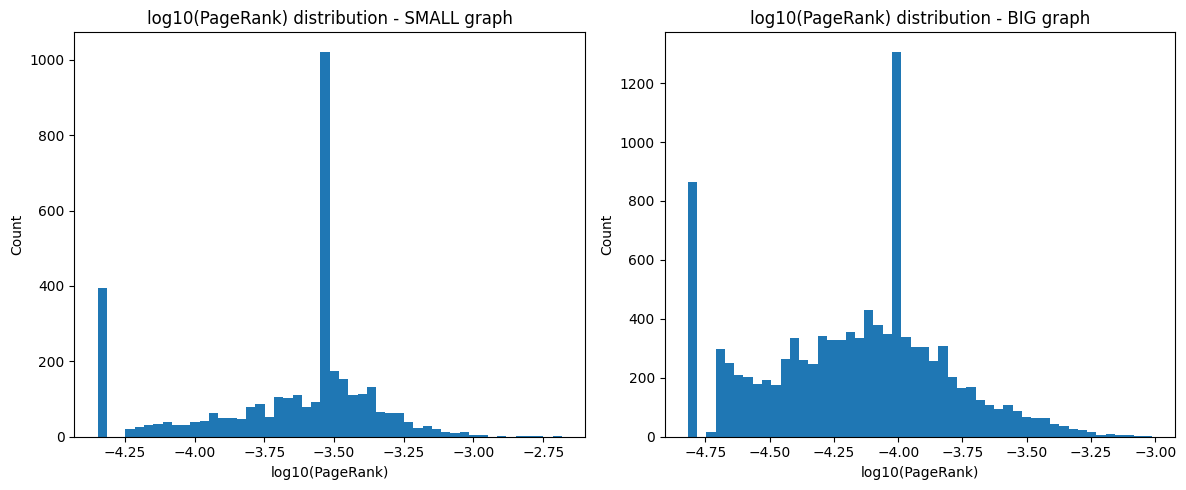

In [34]:
# Histogram of log10(PageRank)
# PageRank values should all be > 0, but we filter to be safe
pr_small_pos = pr_small[pr_small > 0]
pr_big_pos = pr_big[pr_big > 0]
log_pr_small = np.log10(pr_small_pos)
log_pr_big = np.log10(pr_big_pos)

plt.figure(figsize=(12, 5))
# Small
plt.subplot(1, 2, 1)
plt.hist(log_pr_small, bins=50)
plt.title("log10(PageRank) distribution - SMALL graph")
plt.xlabel("log10(PageRank)")
plt.ylabel("Count")
# Big
plt.subplot(1, 2, 2)
plt.hist(log_pr_big, bins=50)
plt.title("log10(PageRank) distribution - BIG graph")
plt.xlabel("log10(PageRank)")
plt.ylabel("Count")

plt.tight_layout()
pr_fig_log_path = os.path.join(figs_dir, "pagerank_distribution_small_vs_big_log10.png")
plt.savefig(pr_fig_log_path, dpi=150)
plt.show()
plt.close()

*Notebook 08 – Scatterplot: degree vs. PageRank*


In [35]:
# Build DataFrames with degree + PageRank for small and big graphs
df_deg_pr_small = (
    degree_small.rename("degree")
    .reset_index()
    .rename(columns={"index": "book_idx"}))
df_deg_pr_small = df_deg_pr_small.merge(
    book_ranks_small[["book_idx", "pagerank"]],
    on="book_idx",
    how="left",)
df_deg_pr_big = (
    degree_big.rename("degree")
    .reset_index()
    .rename(columns={"index": "book_idx"}))
df_deg_pr_big = df_deg_pr_big.merge(
    book_ranks_big[["book_idx", "pagerank"]],
    on="book_idx",
    how="left",)

print("\n[Scatter] Small DF shape:", df_deg_pr_small.shape)
print("[Scatter] Big DF shape:", df_deg_pr_big.shape)

# Filter out zero-degree or zero-pagerank for log scale safety
df_deg_pr_small_pos = df_deg_pr_small[(df_deg_pr_small["degree"] > 0) & (df_deg_pr_small["pagerank"] > 0)]
df_deg_pr_big_pos = df_deg_pr_big[(df_deg_pr_big["degree"] > 0) & (df_deg_pr_big["pagerank"] > 0)]


[Scatter] Small DF shape: (3283, 3)
[Scatter] Big DF shape: (9729, 3)


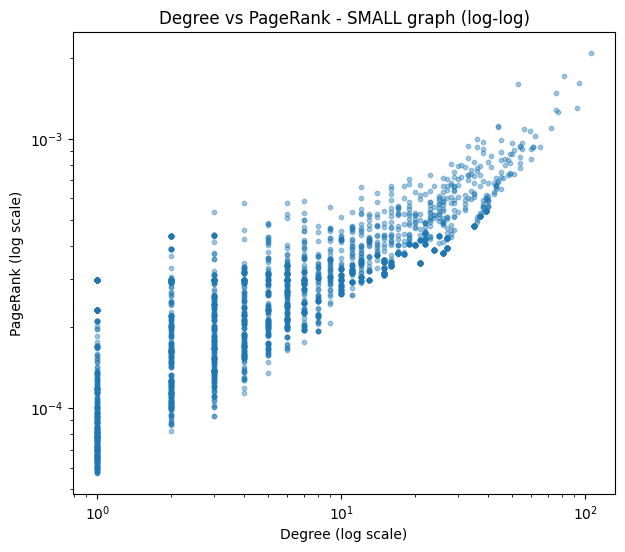

In [36]:
# Scatter plot (log-log) - small graph
plt.figure(figsize=(7, 6))
plt.scatter(
    df_deg_pr_small_pos["degree"],
    df_deg_pr_small_pos["pagerank"],
    alpha=0.4,
    s=10)
plt.xscale("log")
plt.yscale("log")
plt.title("Degree vs PageRank - SMALL graph (log-log)")
plt.xlabel("Degree (log scale)")
plt.ylabel("PageRank (log scale)")

scatter_small_path = os.path.join(figs_dir, "scatter_degree_pagerank_small.png")
plt.savefig(scatter_small_path, dpi=150)
plt.show()
plt.close()

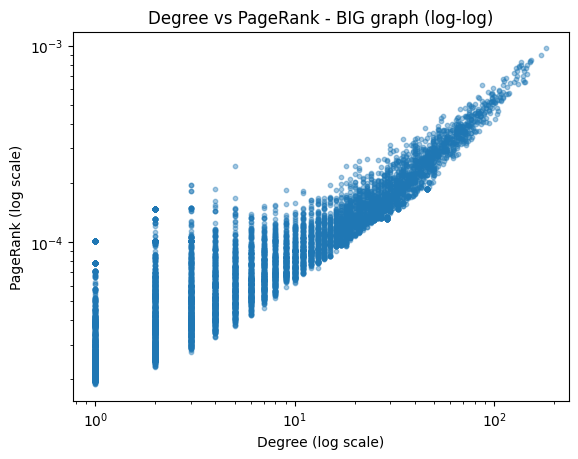

In [37]:
# Scatter plot (log-log) - Big graph
plt.scatter(
    df_deg_pr_big_pos["degree"],
    df_deg_pr_big_pos["pagerank"],
    alpha=0.4,
    s=10)
plt.xscale("log")
plt.yscale("log")
plt.title("Degree vs PageRank - BIG graph (log-log)")
plt.xlabel("Degree (log scale)")
plt.ylabel("PageRank (log scale)")

scatter_big_path = os.path.join(figs_dir, "scatter_degree_pagerank_big.png")
plt.savefig(scatter_big_path, dpi=150)
plt.show()
plt.close()

*Notebook 09 – Spark*


In [38]:
# Initialize Spark session and context
spark = (
    SparkSession.builder
    .appName("BookCooccurrenceSparkBig")
    .master("local[*]")
    .getOrCreate()
)

sc = spark.sparkContext

In [39]:
# Load the big indexed ratings from CSV into a Spark DataFrame
ratings_indexed_big_path = os.path.join(processed_dir, "ratings_core_big_indexed.csv")
print("\n[Spark] Loading ratings from:", ratings_indexed_big_path)

df_indexed_big_spark = (
    spark.read
         .option("header", True)
         .option("inferSchema", True)
         .csv(ratings_indexed_big_path))
print("\n[Spark] df_indexed_big_spark schema:")
df_indexed_big_spark.printSchema()
print("\n[Spark] First rows of df_indexed_big_spark:")
df_indexed_big_spark.show(5)


[Spark] Loading ratings from: /content/algorithms-massive-data-pagerank/data/processed/ratings_core_big_indexed.csv

[Spark] df_indexed_big_spark schema:
root
 |-- user_id: string (nullable = true)
 |-- book_id: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- user_idx: integer (nullable = true)
 |-- book_idx: integer (nullable = true)


[Spark] First rows of df_indexed_big_spark:
+--------------+----------+------+--------+--------+
|       user_id|   book_id|rating|user_idx|book_idx|
+--------------+----------+------+--------+--------+
|A35RQKCCCQ62O0|0395051029|   4.0|    6270|     946|
|A319KYEIAZ3SON|0670569798|   5.0|    5898|    1710|
|A2X86K2EZCV0U1|B000GRDY1O|   4.0|    5580|    7493|
|A1JLKPA3EPLFCP|0774032448|   5.0|    1590|    2432|
|A1I2O9Y3X3HXLS|B000GRORC4|   5.0|    1467|    7526|
+--------------+----------+------+--------+--------+
only showing top 5 rows



In [40]:
# Select only user_idx and book_idx and convert to an RDD of (user_idx, book_idx)
ratings_pairs_rdd = (
    df_indexed_big_spark
        .select("user_idx", "book_idx")
        .rdd
        .map(lambda row: (int(row["user_idx"]), int(row["book_idx"]))))

print("\n[Spark] Example (user_idx, book_idx) pairs:")
print(ratings_pairs_rdd.take(5))


[Spark] Example (user_idx, book_idx) pairs:
[(6270, 946), (5898, 1710), (5580, 7493), (1590, 2432), (1467, 7526)]


In [41]:
# Group by user to get, for each user, the list of books
user_books_rdd = ratings_pairs_rdd.groupByKey()
print("\n[Spark] Example (user_idx, books) after groupByKey:")
example_user_books = user_books_rdd.take(3)
for ub in example_user_books:
    print(ub)


[Spark] Example (user_idx, books) after groupByKey:
(6270, <pyspark.resultiterable.ResultIterable object at 0x7b6c9475f410>)
(5898, <pyspark.resultiterable.ResultIterable object at 0x7b6cab804d70>)
(5580, <pyspark.resultiterable.ResultIterable object at 0x7b6cab8044d0>)


In [42]:
# For each user, generate all book pairs (i, j) with i < j
max_books_per_user_spark = 50  # same idea as in build_book_cooccurrence_edges for the big graph

def user_to_book_pairs(user_books):
    user_idx, books_iter = user_books
    # Convert iterable to a sorted list of unique book indices
    books = sorted(set(books_iter))
    # Skip users with too few books (no edges)
    if len(books) < 2:
        return []
    # Skip users with too many books (to avoid explosion of combinations)
    if max_books_per_user_spark is not None and len(books) > max_books_per_user_spark:
        return []
    # Generate all combinations of 2 different books
    pairs = [((b1, b2), 1) for b1, b2 in combinations(books, 2)]
    return pairs

book_pair_count_rdd = user_books_rdd.flatMap(user_to_book_pairs)
print("\n[Spark] Example ((book_i, book_j), 1) pairs:")
print(book_pair_count_rdd.take(5))


[Spark] Example ((book_i, book_j), 1) pairs:
[((946, 3223), 1), ((946, 3909), 1), ((3223, 3909), 1), ((261, 284), 1), ((261, 304), 1)]


In [43]:
# Reduce by key to count how many users co-reviewed each book pair
cooccurrence_rdd = (
    book_pair_count_rdd
        .reduceByKey(lambda x, y: x + y))

print("\n[Spark] Example ((book_i, book_j), weight) after reduceByKey:")
print(cooccurrence_rdd.take(5))


[Spark] Example ((book_i, book_j), weight) after reduceByKey:
[((946, 3223), 3), ((946, 3909), 1), ((3223, 3909), 4), ((261, 284), 1), ((261, 304), 1)]


In [44]:
# Convert to an RDD of (src_book_idx, dst_book_idx, weight)
edges_triplets_rdd = cooccurrence_rdd.map(
    lambda pair_weight: (
        int(pair_weight[0][0]),  # src_book_idx
        int(pair_weight[0][1]),  # dst_book_idx
        int(pair_weight[1])))

# Convert to a Spark DataFrame
edges_big_spark = edges_triplets_rdd.toDF(
    ["src_book_idx", "dst_book_idx", "weight"])

print("\n[Spark] edges_big_spark schema:")
edges_big_spark.printSchema()
print("\n[Spark] First rows of edges_big_spark:")
edges_big_spark.show(10)
print("\n[Spark] Number of edges in edges_big_spark:", edges_big_spark.count())


[Spark] edges_big_spark schema:
root
 |-- src_book_idx: long (nullable = true)
 |-- dst_book_idx: long (nullable = true)
 |-- weight: long (nullable = true)


[Spark] First rows of edges_big_spark:
+------------+------------+------+
|src_book_idx|dst_book_idx|weight|
+------------+------------+------+
|         946|        3223|     3|
|         946|        3909|     1|
|        3223|        3909|     4|
|         261|         284|     1|
|         261|         304|     1|
|         261|         323|     1|
|         261|         375|     1|
|         261|        1634|     1|
|         261|        1642|     1|
|         261|        1710|     1|
+------------+------------+------+
only showing top 10 rows


[Spark] Number of edges in edges_big_spark: 59205


In [48]:
# Filter by minimum weight (same idea as min_weight in the Python version)
min_weight_spark = 1  # set > 1 if you want to keep only stronger edges

if min_weight_spark is not None and min_weight_spark > 1:
    edges_big_spark = edges_big_spark.filter(edges_big_spark["weight"] >= min_weight_spark)
    print(
        "\n[Spark] Filtered edges with weight <",
        min_weight_spark,
        "- remaining rows:",
        edges_big_spark.count()
    )

# Convert to pandas for comparison with edges_df_big
edges_df_big_spark = edges_big_spark.toPandas()
print("\n[Spark] edges_df_big_spark shape:", edges_df_big_spark.shape)
print(edges_df_big_spark.head())


[Spark] edges_df_big_spark shape: (59205, 3)
   src_book_idx  dst_book_idx  weight
0           946          3223       3
1           946          3909       1
2          3223          3909       4
3           261           284       1
4           261           304       1


In [49]:
# Compare Spark based edges with Python based edges for the big graph
# Keep only the relevant columns and sort both DataFrames
common_cols = ["src_book_idx", "dst_book_idx", "weight"]

edges_py_sorted = (
    edges_df_big[common_cols]
    .sort_values(common_cols)
    .reset_index(drop=True))
edges_sp_sorted = (
    edges_df_big_spark[common_cols]
    .sort_values(common_cols)
    .reset_index(drop=True))

print("\n[Compare] shapes python vs spark:")
print("python:", edges_py_sorted.shape)
print("spark: ", edges_sp_sorted.shape)

# Check if they are exactly the same
same_shape = edges_py_sorted.shape == edges_sp_sorted.shape
same_content = edges_py_sorted.equals(edges_sp_sorted)
print("\n[Compare] same shape:", same_shape)
print("[Compare] same content:", same_content)


[Compare] shapes python vs spark:
python: (59205, 3)
spark:  (59205, 3)

[Compare] same shape: True
[Compare] same content: True


In [50]:
# Save Spark edges to disk as CSV (folder with part files)
edges_big_spark_path = os.path.join(processed_dir, "edges_books_core_big_spark")

print("\n[Spark] Saving edges_big_spark to folder:", edges_big_spark_path)
(edges_big_spark
        .orderBy("src_book_idx", "dst_book_idx")
        .coalesce(1)  # optional: reduce to 1 output file (slower)
        .write
        .option("header", True)
        .mode("overwrite")
        .csv(edges_big_spark_path))


[Spark] Saving edges_big_spark to folder: /content/algorithms-massive-data-pagerank/data/processed/edges_books_core_big_spark
